#### Goal :: Predict the sale (number of items) for the shop-item pair in the  test set. The test set is for one month - November 2015 

In [1]:
from datetime import datetime, timedelta, date
from calendar import monthrange
from pytz import timezone
import pandas as pd
import numpy as np
import feather
import datetime 
import pytz
import csv
import os
import seaborn as sns
import matplotlib.pyplot as plt
import logging

%matplotlib inline

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def get_dates_in_month(year, month, time_zone):
    num_days = monthrange(year, month)[1]
    first_date_of_month = datetime.datetime(year,month,1, tzinfo=time_zone)
    last_date_of_month =  datetime.datetime(year,month,num_days, tzinfo=time_zone)
    return get_dates_inrange(first_date_of_month, last_date_of_month)

def get_dates_inrange(date1, date2):
    if (not isinstance(date1, datetime.datetime)) | (not isinstance(date2, datetime.datetime)):
        return "date1 and date2 should be of type datetime.date"
    num_days = (date2 - date1).days + 1
    date_list = [date1 + datetime.timedelta(days=x) for x in range(0, num_days)]
    return date_list

def remove_nonAlphaNumeric(s: str):
    return re.sub(r'\W+', '', s)

def tokenize(raw_text: str):
    lower_tokens = [w.lower() for w in word_tokenize(raw_text)]
    refined_tokens = [remove_nonAlphaNumeric(w) for w in lower_tokens]
    return list(filter(None, refined_tokens))

def w2v_vectorize(raw_text: str, model):
    words = tokenize(raw_text)
    word_vectors = model.wv
    vector = [0] * model.wv.vector_size
    for word in words:
        if word in word_vectors.vocab:
            vector += word_vectors.get_vector(word)
    vector = [np.round(d, 4) for d in vector]
    return vector


In [2]:
DATA_FOLDER = './data/'
ADD_RESOURCES = './res/'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz')) 

date_df = pd.read_pickle(os.path.join(ADD_RESOURCES, "russian_holidays.pkl"))
geography = pd.read_csv(os.path.join(ADD_RESOURCES, 'geography.csv'))
holidays = feather.read_dataframe(os.path.join(ADD_RESOURCES, 'hol.feather'))

In [3]:
print("training data (sales) -> " + str(sales.shape))
print("test data -> " + str(test.shape))
print("\n")
print("Total Items: {}".format(items.item_id.nunique()))
print("Total Categories: {}".format(item_categories.item_category_id.nunique()))
print("Total Shops: {}".format(shops.shop_id.nunique()))
print("\n--------------------------------------------------------\n")

print("Training data")
print("  # unique shops: {}".format(sales.shop_id.nunique()))
print("  # unique items: {}".format(sales.item_id.nunique()))

print("\n--------------------------------------------------------\n")
print("Test data")
print("  # unique shops: {}".format(test.shop_id.nunique()))
print("  # unique items: {}".format(test.item_id.nunique()))


%matplotlib inline
transactions = sales
# Drop the rows with price lt zero. ther is only one.
transactions = transactions[transactions.item_price > 0]

# Merging to get category_id in the transaction df
transactions = pd.merge(transactions, items[['item_id', 'item_category_id']], on='item_id', how='left')

print("\n\n")

items_test_nottrans = len(set(test.item_id.unique()) - set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
intersection_items_test_transac = len(set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
item_count_test = len(set(test.item_id.unique()))

print("# items in test set: {}".format(item_count_test))
print("# items in test set and transaction set: {}".format(intersection_items_test_transac))
print("# items in test but not transaction: {}".format(items_test_nottrans))

print("\n")

shops_test_nottrans = len(set(test.shop_id.unique()) - set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
intersection_shops_test_transac = len(set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
shop_count_test = len(set(test.shop_id.unique()))

print("# shops in test set: {}".format(shop_count_test))
print("# shops in test set and transaction set: {}".format(intersection_shops_test_transac))
print("# shops in test but not transaction: {}".format(shops_test_nottrans))

print("\n")
 
test.head()

training data (sales) -> (2935849, 6)
test data -> (214200, 3)


Total Items: 22170
Total Categories: 84
Total Shops: 60

--------------------------------------------------------

Training data
  # unique shops: 60
  # unique items: 21807

--------------------------------------------------------

Test data
  # unique shops: 42
  # unique items: 5100



# items in test set: 5100
# items in test set and transaction set: 4737
# items in test but not transaction: 363


# shops in test set: 42
# shops in test set and transaction set: 42
# shops in test but not transaction: 0




,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
print(len(test.item_id.unique()))

len( set(test.item_id.unique()).intersection(set(items.item_id.unique())))

5100


5100

##### Building the shops data frame

In [5]:
# Setting the shop_type
shops_df = shops

shop_types = ['ТЦ', 'ТРК', 'ТРЦ', 'МТРЦ', 'ТК', 'online']
shops_df["shop_type"] = shops_df.shop_name.apply(lambda x: x.split()[1] if x.split()[1] in shop_types else 'OTH')
shops_df.loc[shops_df.shop_id.isin([12, 55]) , 'shop_type'] = "online"
shops_df.loc[shops_df.shop_id == 9 , 'shop_type'] = "outbound"

# Setting the city for each shop
shops_df["city"] = shops_df.shop_name.apply(lambda x: x.split()[0].replace("!", ""))
shops_df.loc[shops_df.city.isin(["Интернет-магазин", "Цифровой", "Выездная"]) , 'city'] = "no_city"

 # Appending the geographic info to shops df
shops_df = pd.merge(shops_df, geography.drop(['city_eng'], axis=1), on='city', how='left')


# Get rid of NaN values from 'time_wrt_utc' and 'dist_from_moscow' columns
# for c in ['time_wrt_utc', 'dist_from_moscow']:
#     shops_df.loc[shops_df[c].isnull(), c] = np.mean(shops_df[c])

# Changing the type to 'category'
catg = ['shop_type', 'city', 'fed_subject', 'fed_dist']
for c in catg:
    shops_df[c] = shops_df[c].astype('category')

print(shops_df.shape)
shops_df.head()

(60, 8)


,shop_name,shop_id,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow
0,"!Якутск Орджоникидзе, 56 фран",0,OTH,Якутск,9.0,Sakha Republic,Far East,8395.0
1,"!Якутск ТЦ ""Центральный"" фран",1,ТЦ,Якутск,9.0,Sakha Republic,Far East,8395.0
2,"Адыгея ТЦ ""Мега""",2,ТЦ,Адыгея,3.0,Adygea Republic,South,1589.0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,ТРК,Балашиха,3.0,Moscow Oblast,Central,26.0
4,"Волжский ТЦ ""Волга Молл""",4,ТЦ,Волжский,3.0,Volgograd Oblast,South,993.0


### These are entries for Online - 'shops'

Выездная Торговля	9	OTH	Выездная	-1	NaN	NaN	-1          (exit trade)

Интернет-магазин ЧС	12	OTH	Интернет-магазин	-1	NaN	NaN	-1   (Online shop Emergency)

Цифровой склад 1С-Онлайн	55	OTH	Цифровой	-1	NaN	NaN	-1 (Digital warehouse 1C-Online)

#### Building a date df, and block_num_info df for adding temporal data.

In [6]:
# setting up the calendar and the Block_num info dataframe

moscow = timezone('Europe/Moscow')
train_first_date = datetime.datetime(2013,1,1, tzinfo=moscow)
train_last_date =  datetime.datetime(2015,11,30, tzinfo=moscow)

date_df = pd.DataFrame(get_dates_inrange(train_first_date, train_last_date), columns=['date'])

date_df['weekday'] = date_df['date'].apply(lambda x: x.isoweekday())
date_df['is_weekend'] = date_df['weekday'] > 5

# Holidays dataframe - (preparing df)
holidays_b = holidays
holidays_b['date_str'] = holidays_b.date.apply(lambda x: x.isoformat().split("T")[0])
holidays_b['off_day'] =  holidays_b.h_type.apply(lambda x: x.split(",")[0] == 'National holiday')
holidays_b['is_holiday'] = True

date_df['date_str'] = date_df.date.apply(lambda x: x.isoformat().split("T")[0])

date_df = pd.merge(date_df, holidays_b[['date_str', 'is_holiday']], on='date_str', how='left')
date_df['is_holiday'].fillna(False, inplace=True)

date_df = pd.merge(date_df, holidays_b[['off_day', 'date_str']], on='date_str', how='left')
date_df.loc[date_df.loc[:, 'weekday'] > 5, 'off_day'] = True


def add_date_block_num(d):
    if(d.year == 2013):
        base=0
    elif(d.year == 2014):
        base=12
    elif(d.year == 2015): 
        base=24
    return base + (d.month-1)

date_df['date_block_num'] = date_df['date'].apply(lambda x: add_date_block_num(x))

date_df.head()


# Block info df
block_num_info = date_df[date_df.is_weekend == True].groupby('date_block_num')['is_weekend'].sum().reset_index(name = "weekends")

block_num_info['holidays'] = date_df[date_df.is_holiday == True].groupby('date_block_num')['is_holiday'].sum()
block_num_info['holidays'].fillna(0, inplace=True)

block_num_info['off_days'] = date_df[date_df.off_day == True].groupby('date_block_num')['off_day'].sum()
block_num_info['off_days'].fillna(0, inplace=True)

block_num_info.head()

,date_block_num,weekends,holidays,off_days
0,0,8.0,7.0,14
1,1,8.0,2.0,8
2,2,10.0,2.0,11
3,3,8.0,0.0,8
4,4,8.0,9.0,16


#### Build the initial training df

In [7]:
from datetime import datetime, date, time

# 'sales' is the input training dataframe
#sales['date'] = pd.to_datetime(sales['date'])

sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


<Figure size 432x288 with 0 Axes>

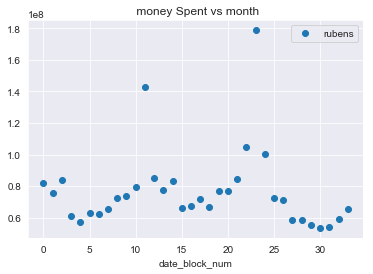

In [8]:
# Money spent every month ( We see the seasonality!)
plt.clf()
total_transactions_monthly = sales[sales['item_cnt_day'] > 0].groupby('date_block_num')['item_price'].sum().reset_index(name = "rubens")
sns.set_style("darkgrid")
total_transactions_monthly.plot(x='date_block_num', y='rubens', style='o')
plt.title(" money Spent vs month")
plt.show()

In [9]:
# remove date column
sales_monthly = sales #.drop(['date'], axis=1)

# Aggregating item_cnt_day (summing) and item_price(averaging)
agg_funcs = {'item_cnt_day':np.sum, 'item_price':np.mean}
sales_monthly = sales_monthly.groupby(['date_block_num', 'shop_id', 'item_id']).agg(agg_funcs).reset_index()

# rename the columns
sales_monthly.rename(columns={'item_price':'item_avg_price', 'item_cnt_day':'item_cnt_month'}, inplace=True)

# Adding month numbers (jan1, feb-2, march-3....dec-12)
sales_monthly['month'] = (sales_monthly['date_block_num'] % 12)+1

# Appending

# shop information
sales_monthly = pd.merge(sales_monthly, shops_df, on='shop_id', how='left')

# block_num_info (temporal features)
sales_monthly = pd.merge(sales_monthly, block_num_info, on='date_block_num', how='left')

# item info
sales_monthly = pd.merge(sales_monthly, items, on='item_id', how='left')

print(sales_monthly.shape)

sales_monthly.head()

(1609124, 18)


,date_block_num,shop_id,item_id,item_cnt_month,item_avg_price,month,shop_name,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow,weekends,holidays,off_days,item_name,item_category_id
0,0,0,32,6.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,1+1,40
1,0,0,33,3.0,347.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,1+1 (BD),37
2,0,0,35,1.0,247.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,10 ЛЕТ СПУСТЯ,40
3,0,0,43,1.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,100 МИЛЛИОНОВ ЕВРО,40
4,0,0,51,2.0,128.5,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,Sakha Republic,Far East,8395.0,8.0,7.0,14,100 лучших произведений классики (mp3-CD) (Dig...,57


#### Word2Vec
Train the word2vec model on item-names


In [10]:
import nltk
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec

# Input to Word2Vec is ->
# [['at', 't', 'worldwid', 'prepaid', 'phone', 'card'],
#  ['pk', 'religi', 'cand', 'milagro', 'de', 'tepeyac'],
#  ['jenna', 'bra', 'yelw', 'dsv', 'onli'],
#  ['davinci', 'jenni', 'lind', 'stationari', 'crib', 'eboni'],
#  ['slice', 'toaster', 'white', 'pk']] - > Array(Array(String))

newpath = r'./word2vec' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

items = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))

tokenized_item_names = list(items['item_name'].apply(tokenize))

model = Word2Vec(
    tokenized_item_names,
    size = 50,
    window = 5,
    min_count = 3,
    workers = 6)

model.train(tokenized_item_names, total_examples = len(tokenized_item_names), epochs=30)
model.save("./word2vec/item_names_word2vec.model")


C:\Users\purne\Miniconda3\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
2019-02-18 22:16:47,424 : INFO : 'pattern' package not found; tag filters are not available for English
2019-02-18 22:16:49,825 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2019-02-18 22:16:49,825 : INFO : collecting all words and their counts
2019-02-18 22:16:49,825 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-18 22:16:49,837 : INFO : PROGRESS: at sentence #10000, processed 69241 words, keeping 10258 word types
2019-02-18 22:16:49,847 : INFO : PROGRESS: at sentence #20000, processed 120597 words, keeping 17750 word types
2019-02-18 22:16:49,850 : INFO : collected 19154 word types from a corpus of 133510 raw words and 22170 sentences
2019-02-18 22:16:49,851 : INFO : Loading a fresh vocabulary
2019

In [11]:
# Generate the items_vec_df. features -> ['iv1', 'iv2', 'iv3',......'iv100']

items_vec_df = items
items_vec_df['item_vector'] = items_vec_df['item_name'].apply(lambda x: w2v_vectorize(x, model))

b = np.array(range(0,model.wv.vector_size))
b = [str(x) for x in b]
z = []
for x in b:
    z.append('iv'+x)

temp = pd.DataFrame(items_vec_df.item_vector.tolist(), columns=z)
items_vec_df.drop('item_vector', axis=1, inplace=True)
items_vec_df = pd.concat([items_vec_df, temp], axis=1)

items_vec_df.head()

,item_name,item_id,item_category_id,iv0,iv1,iv2,iv3,iv4,iv5,iv6,...,iv40,iv41,iv42,iv43,iv44,iv45,iv46,iv47,iv48,iv49
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,0.7016,-0.2077,0.3475,-0.9564,0.4632,0.2008,-0.5481,...,1.3649,-0.2245,-1.1344,-0.1566,1.2741,0.9208,-0.7797,-0.4763,-0.5572,0.4777
1,!ABBYY FineReader 12 Professional Edition Full...,1,76,-10.2165,-1.2581,6.4800,2.1307,3.7471,13.2242,-2.4687,...,2.4462,1.4264,-17.1839,-7.1674,0.6959,2.3287,-5.7547,2.5191,3.7157,1.7755
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,3.5956,-0.1060,-1.3064,-2.3966,-0.7508,1.5329,-1.8026,...,2.3443,-0.9587,0.2872,-1.6738,-3.0662,1.9063,-0.5870,-2.5061,-4.3043,0.4823
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,0.4640,0.1030,0.4052,0.2427,1.0238,0.8774,-0.0306,...,0.5998,0.3162,-1.4966,0.2640,1.4573,0.6094,-0.9060,0.0142,-0.4682,0.2957
4,***КОРОБКА (СТЕКЛО) D,4,40,-0.1306,0.9320,0.4177,0.3348,0.9776,1.3515,-1.0336,...,0.4669,0.2349,-2.7100,0.0161,1.2365,0.2226,-1.5777,0.1913,-0.3190,-0.3875


In [12]:
items_vec_df.drop(columns=["item_category_id", "item_name"], inplace=True)
items_vec_df.head()

,item_id,iv0,iv1,iv2,iv3,iv4,iv5,iv6,iv7,iv8,...,iv40,iv41,iv42,iv43,iv44,iv45,iv46,iv47,iv48,iv49
0,0,0.7016,-0.2077,0.3475,-0.9564,0.4632,0.2008,-0.5481,-0.2007,-0.2543,...,1.3649,-0.2245,-1.1344,-0.1566,1.2741,0.9208,-0.7797,-0.4763,-0.5572,0.4777
1,1,-10.2165,-1.2581,6.4800,2.1307,3.7471,13.2242,-2.4687,-12.7418,12.6134,...,2.4462,1.4264,-17.1839,-7.1674,0.6959,2.3287,-5.7547,2.5191,3.7157,1.7755
2,2,3.5956,-0.1060,-1.3064,-2.3966,-0.7508,1.5329,-1.8026,0.4600,-2.1477,...,2.3443,-0.9587,0.2872,-1.6738,-3.0662,1.9063,-0.5870,-2.5061,-4.3043,0.4823
3,3,0.4640,0.1030,0.4052,0.2427,1.0238,0.8774,-0.0306,-0.0522,0.3401,...,0.5998,0.3162,-1.4966,0.2640,1.4573,0.6094,-0.9060,0.0142,-0.4682,0.2957
4,4,-0.1306,0.9320,0.4177,0.3348,0.9776,1.3515,-1.0336,-0.8806,1.1659,...,0.4669,0.2349,-2.7100,0.0161,1.2365,0.2226,-1.5777,0.1913,-0.3190,-0.3875


In [13]:
sales_monthly_ext = pd.merge(sales_monthly, items_vec_df, on='item_id', how='left')
sales_monthly_ext.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_avg_price,month,shop_name,shop_type,city,time_wrt_utc,...,iv40,iv41,iv42,iv43,iv44,iv45,iv46,iv47,iv48,iv49
0,0,0,32,6.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,...,0.3566,0.5502,-0.8563,-0.2069,1.7178,0.2810,-1.0862,-0.0453,-0.5737,0.0987
1,0,0,33,3.0,347.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,...,0.5775,-1.4220,-3.6628,-1.5782,3.0000,1.6149,-2.9767,0.0823,-1.0935,-0.4610
2,0,0,35,1.0,247.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,...,0.8549,1.8292,-1.9485,-0.1621,1.0428,4.4827,-1.8161,-1.2985,-3.9845,-0.8285
3,0,0,43,1.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,...,-0.1692,0.4924,-1.2545,0.7963,1.5012,1.2882,1.9808,-0.4359,-0.5554,-1.3967
4,0,0,51,2.0,128.5,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,...,1.4048,0.8934,0.1243,3.5812,8.7516,10.7346,7.4210,3.0092,-0.6006,-5.9277


### Observation:
1. In-store transactions are decreasing every month !!

2. Online sales are increasing !!

3. The total transactions are decreasing every month.... this is surprising !!

In [135]:
# # Online vs In-store sales

# phy_stores_list = list(set(shops_df.shop_id) ^ set([12,55]))

# plt.clf()
# total_transactions_monthly = sales_monthly.groupby('date_block_num').size().reset_index(name = "trans_count")
# sns.set_style("darkgrid")
# total_transactions_monthly.plot(x='date_block_num', y='trans_count', style='o')
# plt.title(" Total Transactions vs month")
# plt.show()

# plt.clf()
# online_transactions_monthly = sales_monthly[sales_monthly['shop_id'].isin([12,55])].groupby('date_block_num').size().reset_index(name = "trans_count")
# sns.set_style("darkgrid")
# online_transactions_monthly.plot(x='date_block_num', y='trans_count', style='o')
# plt.title("Online Transactions vs month")
# plt.show()

# plt.clf()
# instore_transactions_monthly = sales_monthly[sales_monthly['shop_id'].isin(phy_stores_list)].groupby('date_block_num').size().reset_index(name = "trans_count")
# sns.set_style("darkgrid")
# instore_transactions_monthly.plot(x='date_block_num', y='trans_count', style='o')
# plt.title("In Store Transactions vs month")
# plt.show()


# x = sales_monthly.groupby('date_block_num')['item_id'].nunique().reset_index()
# x.rename(columns={'item_id':'num_items'}, inplace=True)


# plt.clf()
# sns.set_style("darkgrid")
# x.plot(x='date_block_num', y='num_items', style='o')
# plt.title("Unique items every month")
# plt.show()

In [136]:
# plt.clf()

# # Plot the shopi-transactions
# sns.set_color_codes("muted")
# f, ax = plt.subplots(figsize=(8, 12))
# sns.set(font_scale=1.5)

# sns.countplot(y="shop_id", data=sales_monthly, palette="Greens_d", order = sales_monthly['shop_id'].value_counts().index)

# plt.title("Distribution of transactions across shops")
# plt.show()

In [191]:
# sales_monthly.groupby("shop_id")['item_id'].nunique()
# test.groupby("shop_id").size().reset_index(name = "trans_count_for_the_shop")


In [137]:
# plt.clf()

# # Plot the shopid-transactions
# sns.set_color_codes("muted")
# f, ax = plt.subplots(figsize=(10, 22))
# sns.set(font_scale=1.5)

# sns.countplot(y="item_category_id", data=sales_monthly, palette="Greens_d",
#               order = sales_monthly['item_category_id'].value_counts().index)

# plt.title("Distribution of item-categories in the monthly transaction data")
# plt.show()

In [18]:
# item_catgs = [51, 10, 1, 50, 0, 52, 53, 48, 27, 36, 18, 46, 74, 26, 34, 68, 9, 44, 13,
#               17, 80, 8, 81, 39, 82, 54, 42, 79, 16, 71, 4, 60, 76, 78]
# plt.clf()

# # Plot the shopi-transactions
# sns.set_color_codes("muted")
# f, ax = plt.subplots(figsize=(10, 22))
# sns.set(font_scale=1.5)
# df = sales_monthly[sales_monthly['item_category_id'].isin(item_catgs)]

# sns.countplot(y="item_category_id", data=sales_monthly[sales_monthly['item_category_id'].isin(item_catgs)],
#               palette="Greens_d", order = df['item_category_id'].value_counts().index)
# plt.title("Distribution of Item categories( with count < 1650) in monthly transaction data")
# plt.show()

In [6]:
# items.head(100)

In [5]:
# item_categories

## Model Training

In [14]:
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\purne\Miniconda3\envs\py36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [15]:
print(sales_monthly_ext.columns.tolist())

['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_avg_price', 'month', 'shop_name', 'shop_type', 'city', 'time_wrt_utc', 'fed_subject', 'fed_dist', 'dist_from_moscow', 'weekends', 'holidays', 'off_days', 'item_name', 'item_category_id', 'iv0', 'iv1', 'iv2', 'iv3', 'iv4', 'iv5', 'iv6', 'iv7', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12', 'iv13', 'iv14', 'iv15', 'iv16', 'iv17', 'iv18', 'iv19', 'iv20', 'iv21', 'iv22', 'iv23', 'iv24', 'iv25', 'iv26', 'iv27', 'iv28', 'iv29', 'iv30', 'iv31', 'iv32', 'iv33', 'iv34', 'iv35', 'iv36', 'iv37', 'iv38', 'iv39', 'iv40', 'iv41', 'iv42', 'iv43', 'iv44', 'iv45', 'iv46', 'iv47', 'iv48', 'iv49']


In [16]:
# Feature  List  

numeric_var = list(["holidays", "off_days","weekends"]) + z # "dist_from_moscow"
categ_var = list(['shop_id' , 'item_category_id', 'month']) # 'item_id', 'shop_type', 'time_wrt_utc', 'city', 'fed_subject', 'fed_dist'
text_var  = list(['item_name']) #'shop_name'

features = numeric_var + categ_var + text_var

target_var = list(['item_cnt_month'])

sales_monthly_ext[categ_var] = sales_monthly_ext[categ_var].apply(lambda x: x.astype('category'))
sales_monthly_ext[numeric_var] = sales_monthly_ext[numeric_var].apply(lambda x: pd.to_numeric(x, downcast='float'))
sales_monthly_ext[text_var] = sales_monthly_ext[text_var].apply(lambda x: x.astype('str'))

sales_monthly_ext.head(4)

,date_block_num,shop_id,item_id,item_cnt_month,item_avg_price,month,shop_name,shop_type,city,time_wrt_utc,...,iv40,iv41,iv42,iv43,iv44,iv45,iv46,iv47,iv48,iv49
0,0,0,32,6.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,...,0.3566,0.5502,-0.8563,-0.2069,1.7178,0.2810,-1.0862,-0.0453,-0.5737,0.0987
1,0,0,33,3.0,347.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,...,0.5775,-1.4220,-3.6628,-1.5782,3.0000,1.6149,-2.9767,0.0823,-1.0935,-0.4610
2,0,0,35,1.0,247.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,...,0.8549,1.8292,-1.9485,-0.1621,1.0428,4.4827,-1.8161,-1.2985,-3.9845,-0.8285
3,0,0,43,1.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9.0,...,-0.1692,0.4924,-1.2545,0.7963,1.5012,1.2882,1.9808,-0.4359,-0.5554,-1.3967


#### train-test split

In [17]:
data = sales_monthly_ext[features + target_var + list(["date_block_num", "item_id"])]

data.head()

vald = data[data.date_block_num == 25]
train = data[data.date_block_num < 25]

print(train.shape)
print(vald.shape)

y_train = train[target_var]
x_train = train[features]

y_vald = vald[target_var]
x_vald = vald[features]

(1302044, 60)
(41390, 60)


#### Baseline model - A simple model which takes the average of the sales from last 4 months for each shop-item pair

In [18]:
import math

from sklearn import metrics

df = train[train.date_block_num.isin([21, 22, 23, 24])][['shop_id', 'item_id', 'date_block_num', 'item_cnt_month']]
df1 = df.groupby(['shop_id', 'item_id'])['item_cnt_month'].mean().reset_index(name="avg_item_cnt")
df1['avg_item_cnt'] = df1['avg_item_cnt'].apply(np.round)

pred = pd.merge(vald, df1, on=['shop_id', 'item_id'], how='left')
pred = pred[['shop_id', 'item_id', 'avg_item_cnt', 'item_cnt_month']]
pred = pred['avg_item_cnt'].fillna(np.round(pred.avg_item_cnt.mean()))

print('Mean Absolute Error:', metrics.mean_absolute_error(vald.item_cnt_month, pred))
print('Mean Squared Error:', metrics.mean_squared_error(vald.item_cnt_month, pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(vald.item_cnt_month, pred)))

print("\nAvg. count for each shop-item pair: {}".format(vald.item_cnt_month.mean()))

pct = metrics.mean_absolute_error(vald.item_cnt_month, pred) / vald.item_cnt_month.mean() * 100
print("MAPE is {} percent of avg_scan_count".format(np.round(pct,2)))

Mean Absolute Error: 1.7836917129741483
Mean Squared Error: 48.620367238463395
Root Mean Squared Error: 6.972830647481939

Avg. count for each shop-item pair: 2.0342594829669003
MAPE is 87.68 percent of avg_scan_count


###### 'How have the items been chosen for the test set? '.
###### There are 5100 items in the test set out of which 4737 appear in the training data; 363 are not in the training data. Smilar split can appear in the private-test set.

In [19]:
# define a custom cross-validator
from sklearn.model_selection import BaseCrossValidator

class CustomCVSplit(BaseCrossValidator):
    def __init__(self, n_splits=3):
        self.n_splits = n_splits
    
    def split(self, X, y=None, groups=None):
        L = len(groups.unique())
        assert self.n_splits < L

        start_block_num = L - self.n_splits
        end_block_num = L-1
        
        for i in range(start_block_num, end_block_num+1):
            test_index = groups[groups == i].index
            train_index = groups[groups.isin(list(range(0,i)))].index
            yield np.asarray(train_index), np.asarray(test_index)
    
    def get_n_splits(self, X, y=None, groups=None):
        return self.n_splits
    
# testing the cv
groups = data.date_block_num
cv = CustomCVSplit(n_splits=5)
i=0
for train,test in cv.split(data, np.asarray(data), groups=groups):
    i+=1
    print("Train: {} len: {}".format(train, len(train)))
    print("Test: {} len: {}".format(test, len(test)))
    print("\n\n")

Train: [      0       1       2 ... 1448990 1448991 1448992] len: 1448993
Test: [1448993 1448994 1448995 ... 1480899 1480900 1480901] len: 31909



Train: [      0       1       2 ... 1480899 1480900 1480901] len: 1480902
Test: [1480902 1480903 1480904 ... 1514426 1514427 1514428] len: 33527



Train: [      0       1       2 ... 1514426 1514427 1514428] len: 1514429
Test: [1514429 1514430 1514431 ... 1547912 1547913 1547914] len: 33486



Train: [      0       1       2 ... 1547912 1547913 1547914] len: 1547915
Test: [1547915 1547916 1547917 ... 1577590 1577591 1577592] len: 29678



Train: [      0       1       2 ... 1577590 1577591 1577592] len: 1577593
Test: [1577593 1577594 1577595 ... 1609121 1609122 1609123] len: 31531





#### Transformers

In [20]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
        
        
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column_list):
        self.column_list = column_list   
    def fit(self, X, y=None):
        return self   
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.column_list]

#### Models

In [21]:
# DeepLearning

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

# define base model
def deep_model():
    # create model
    model = Sequential()
    model.add(Dense(159, input_dim=159, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# evaluate model with standardized dataset
dnn = KerasRegressor(build_fn=deep_model, epochs=1000, batch_size=5000, verbose=0)


Using TensorFlow backend.


In [22]:
# RandomForest

from sklearn.ensemble import RandomForestRegressor

rand_forest_regressor = RandomForestRegressor(n_estimators=5, random_state=0, max_depth=25 , n_jobs=-1, verbose=100)


#### Feature preprocessing pipeline

In [23]:
# Pipelines
one_hot_encode = Pipeline([
    ('extract_columns', ColumnSelector(['shop_id', 'month'])),
    ('one_hot_encoding', OneHotEncoder())
])


# random-forest features
rand_forest_feats = FeatureUnion([
    ('numeric_feats', TypeSelector(dtype=np.number)),
    ('one_hot_encoded_feats', one_hot_encode)
])

In [43]:
# print(shops_df.dtypes)
# print("\n")
# print(len(shops_df.shop_type.unique()) +
#       len(shops_df.city.unique()) +
#       len(shops_df.fed_subject.unique()) +
#       len(shops_df.fed_dist.unique())
#      )

# print(len(shops_df.shop_id.unique()))


shop_name             object
shop_id                int64
shop_type           category
city                category
time_wrt_utc         float64
fed_subject         category
fed_dist            category
dist_from_moscow     float64
dtype: object


66
60


#### Final pipeline

In [24]:
# Random-forest pipeline
rand_forest_pipeline = Pipeline([
    ('rand_forest_feats',rand_forest_feats),
    ('rand_forest_regressor', rand_forest_regressor)
])

In [25]:
from sklearn.externals import joblib
help(joblib.parallel)

# fit and predict
rand_forest_pipeline.fit(x_train, y_train)   
# print(len(one_hot_encode.fit_transform(x_train, y_train).toarray()[0]))

# print( len(x_train.month.unique()) ,  len(x_train.shop_id.unique()))

Help on module sklearn.externals.joblib.parallel in sklearn.externals.joblib:

NAME
    sklearn.externals.joblib.parallel - Helpers for embarrassingly parallel code.

CLASSES
    builtins.object
        BatchCompletionCallBack
        BatchedCalls
    sklearn.externals.joblib.logger.Logger(builtins.object)
        Parallel
    
    class BatchCompletionCallBack(builtins.object)
     |  Callback used by joblib.Parallel's multiprocessing backend.
     |  
     |  This callable is executed by the parent process whenever a worker process
     |  has returned the results of a batch of tasks.
     |  
     |  It is used for progress reporting, to update estimate of the batch
     |  processing duration and to schedule the next batch of tasks to be
     |  processed.
     |  
     |  Methods defined here:
     |  
     |  __call__(self, out)
     |      Call self as a function.
     |  
     |  __init__(self, dispatch_timestamp, batch_size, parallel)
     |      Initialize self.  See help(typ

Pipeline(memory=None,
     steps=[('rand_forest_feats', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric_feats', TypeSelector(dtype=<class 'numpy.number'>)), ('one_hot_encoded_feats', Pipeline(memory=None,
     steps=[('extract_columns', ColumnSelector(column_list=['shop_id', 'month'])), ('one_hot_encoding', OneHotEn...stimators=5, n_jobs=-1,
           oob_score=False, random_state=0, verbose=100, warm_start=False))])

In [27]:
rf_predictions = np.round(rand_forest_pipeline.predict(x_vald))

[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    0.0s finished


In [30]:
from sklearn.metrics import mean_squared_error

print('Mean Absolute Error:', metrics.mean_absolute_error(vald.item_cnt_month, rf_predictions))
print('Mean Squared Error:', metrics.mean_squared_error(vald.item_cnt_month, rf_predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(vald.item_cnt_month, rf_predictions)))
print("\nAvg. count for each shop-item pair: {}".format(np.round(vald.item_cnt_month.mean(), 3)))

pct = metrics.mean_absolute_error(vald.item_cnt_month, rf_predictions) / vald.item_cnt_month.mean() * 100
print("MAPE is {} percent of avg_scan_count".format(np.round(pct,2)))

Mean Absolute Error: 1.593162599661754
Mean Squared Error: 42.0776757670935
Root Mean Squared Error: 6.4867307456910455

Avg. count for each shop-item pair: 2.034
MAPE is 78.32 percent of avg_scan_count


#### Cross-validation (for hyperparams tuning)

In [ ]:
# kfold = KFold(n_splits=10, random_state=seed)
custom_cv = CustomCVSplit(n_splits=5)
results = cross_val_score(pipeline, x_train, y_train, cv=custom_cv, scoring='r2', groups=groups)
print(results)